In [1]:
# !pip install pymongo

In [3]:
# pip install --upgrade scikit-learn==1.8.0

🚀 Fetching latest data and generating 1 Week visualization...

DATE            | PM2.5 (μg/m³)   | AQI INDEX    | CATEGORY                  | TYPE      
-----------------------------------------------------------------------------------------------
Feb 05 (Thu)    |        36.89    |       104    | Unhealthy (Sensitive)     | Observed  
Feb 06 (Fri)    |        29.12    |        87    | Moderate                  | Observed  
Feb 07 (Sat)    |        42.16    |       117    | Unhealthy (Sensitive)     | Observed  
Feb 08 (Sun)    |        48.59    |       133    | Unhealthy (Sensitive)     | Observed  
Feb 09 (Mon)    |        35.66    |       101    | Unhealthy (Sensitive)     | Predicted 
Feb 10 (Tue)    |        38.23    |       108    | Unhealthy (Sensitive)     | Predicted 
Feb 11 (Wed)    |        38.72    |       109    | Unhealthy (Sensitive)     | Predicted 


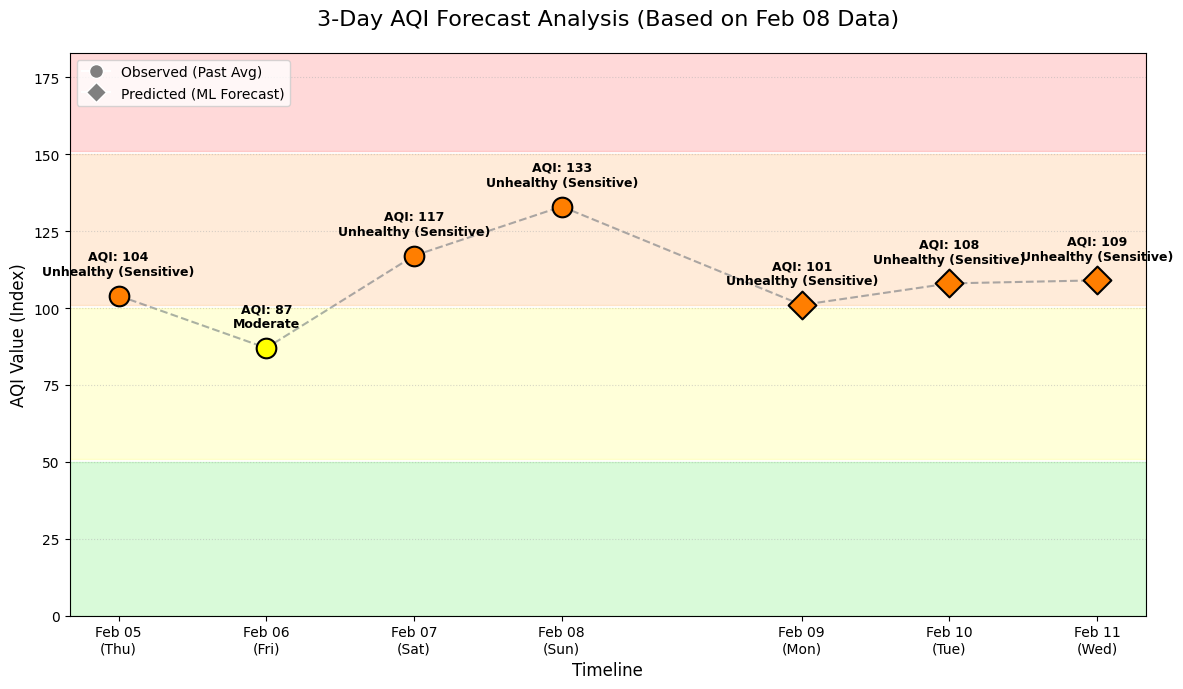

In [4]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv
from pymongo import MongoClient

# Load variables from .env file for local development
load_dotenv()

# --- CONFIG ---
MONGO_URI = os.getenv("MONGO_URI")
DB_NAME = "aqi_predictor"
RAW_COLLECTION = "raw_data"
FEATURE_COLLECTION = "feature_store"
MODEL_PATH = "models/aqi_multi_output_model.pkl"

def calculate_aqi(pm25):
    """This function converts PM2.5 value to actual AQI index value
    Formula used: AQI = (upper_AQI − lower_AQI) / (upper_PM25 − lower_PM25) × (PM25 − lower_PM25) + lower_AQI"""
    if pm25 < 0: return 0

    # Range: 0.0 – 12.0 (Good)
    if pm25 <= 12.0:
        return round(((50 - 0) / (12.0 - 0)) * (pm25 - 0) + 0)

    # Range: 12.1 – 35.4 (Moderate)
    elif pm25 <= 35.4:
        return round(((100 - 51) / (35.4 - 12.1)) * (pm25 - 12.1) + 51)

    # Range: 35.5 – 55.4 (Unhealthy for Sensitive Groups)
    elif pm25 <= 55.4:
        return round(((150 - 101) / (55.4 - 35.5)) * (pm25 - 35.5) + 101)

    # Range: 55.5 – 150.4 (Unhealthy)
    elif pm25 <= 150.4:
        return round(((200 - 151) / (150.4 - 55.5)) * (pm25 - 55.5) + 151)

    # Range: 150.5 – 250.4 (Very Unhealthy)
    elif pm25 <= 250.4:
        return round(((300 - 201) / (250.4 - 150.5)) * (pm25 - 150.5) + 201)

    # Range: 250.5 – 500.4 (Hazardous)
    elif pm25 <= 500.4:
        return round(((500 - 301) / (500.4 - 250.5)) * (pm25 - 250.5) + 301)

    # Anything above 500.4 is off the charts
    return 500

def get_aqi_info(aqi_val):
    """Returns Category Name and official Color Code"""
    if aqi_val <= 50: return ("Good", "#00e400")
    elif aqi_val <= 100: return ("Moderate", "#ffff00")
    elif aqi_val <= 150: return ("Unhealthy (Sensitive)", "#ff7e00")
    elif aqi_val <= 200: return ("Unhealthy", "#ff0000")
    elif aqi_val <= 300: return ("Very Unhealthy", "#8f3f97")
    else: return ("Hazardous", "#7e0023")

def main():
    print("🚀 Fetching latest data and generating 1 Week visualization...")
    payload = joblib.load(MODEL_PATH)
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]

    # Get latest raw data (Past 7 Days)
    history = list(db[RAW_COLLECTION].find().sort("datetime", -1).limit(96))
    hist_df = pd.DataFrame(history).sort_values("datetime")
    hist_df['datetime'] = pd.to_datetime(hist_df['datetime'])
    present_time = hist_df['datetime'].iloc[-1]

    # Get the latest launchpad feature
    latest_feat = list(db[FEATURE_COLLECTION].find().sort("datetime", -1).limit(1))[0]
    client.close()

    # Predict
    forecast_pm25 = np.maximum(payload['model'].predict(pd.DataFrame([latest_feat])[payload['features']])[0], 0)

    # --- DATA ALIGNMENT ---
    plot_dates, pm_values, aqi_values, types = [], [], [], []

    # Process Observed (Daily Averages for last 4 days)
    for d in [3, 2, 1, 0]:
        t_date = (present_time - timedelta(days=d)).date()
        day_data = hist_df[hist_df['datetime'].dt.date == t_date]
        if not day_data.empty:
            avg_pm = day_data['pm2_5'].mean()
            aqi = calculate_aqi(avg_pm)
            plot_dates.append(datetime.combine(t_date, datetime.min.time()))
            pm_values.append(avg_pm)
            aqi_values.append(aqi)
            types.append("Observed")

    # Process Predicted (Next 3 days)
    for i, h in enumerate([24, 48, 72]):
        f_dt = present_time + timedelta(hours=h)
        aqi = calculate_aqi(forecast_pm25[i])
        plot_dates.append(f_dt)
        pm_values.append(forecast_pm25[i])
        aqi_values.append(aqi)
        types.append("Predicted")

    # --- FORMATTED PRINTING ---
    print("\n" + "="*95)
    header = f"{'DATE':<15} | {'PM2.5 (μg/m³)':<15} | {'AQI INDEX':<12} | {'CATEGORY':<25} | {'TYPE':<10}"
    print(header)
    print("-" * 95)

    for i in range(len(plot_dates)):
        cat, _ = get_aqi_info(aqi_values[i])
        row = (f"{plot_dates[i].strftime('%b %d (%a)'):<15} | "
               f"{pm_values[i]:>12.2f}    | "
               f"{aqi_values[i]:>9}    | "
               f"{cat:<25} | "
               f"{types[i]:<10}")
        print(row)
    print("="*95)

    # --- THE PLOT ---
    plt.figure(figsize=(12, 7))

    # 1. Background AQI Color Bands
    plt.axhspan(0, 50, color='#00e400', alpha=0.15, label='Good')
    plt.axhspan(51, 100, color='#ffff00', alpha=0.15, label='Moderate')
    plt.axhspan(101, 150, color='#ff7e00', alpha=0.15, label='Unhealthy (Sensitive)')
    plt.axhspan(151, 200, color='#ff0000', alpha=0.15, label='Unhealthy')

    # 2. Plot the line
    plt.plot(plot_dates, aqi_values, color='#2c3e50', linestyle='--', alpha=0.4, zorder=1)

    # 3. Plot individual markers with category colors
    for i in range(len(plot_dates)):
        cat_name, cat_color = get_aqi_info(aqi_values[i])
        marker_style = 'o' if types[i] == "Observed" else 'D' # Circle for past, Diamond for future

        plt.scatter(plot_dates[i], aqi_values[i], color=cat_color, s=200,
                    edgecolors='black', linewidth=1.5, zorder=5, marker=marker_style)

        # Label each point
        plt.annotate(f"AQI: {aqi_values[i]}\n{cat_name}",
                     (plot_dates[i], aqi_values[i]),
                     xytext=(0, 15), textcoords='offset points',
                     ha='center', fontsize=9, fontweight='bold')

    # 4. Chart Styling
    plt.title(f"3-Day AQI Forecast Analysis (Based on {present_time.strftime('%b %d')} Data)", fontsize=16, pad=20)
    plt.ylabel("AQI Value (Index)", fontsize=12)
    plt.xlabel("Timeline", fontsize=12)
    plt.xticks(plot_dates, [d.strftime('%b %d\n(%a)') for d in plot_dates])
    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.ylim(0, max(aqi_values) + 50)

    # Custom Legend to explain markers
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Observed (Past Avg)', markerfacecolor='gray', markersize=10),
        Line2D([0], [0], marker='D', color='w', label='Predicted (ML Forecast)', markerfacecolor='gray', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()